## Imports

In [66]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

An example function to cement the important concepts

In [67]:
def f(x):
    return 3*x**2-4*x+5

Building a range of values to feed in the function and plotting it against it's f(x) results

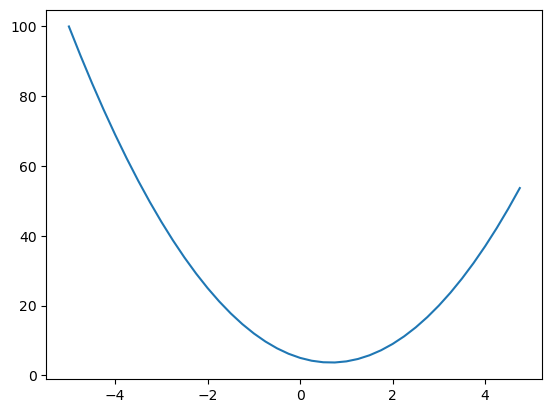

In [68]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys);

Derivatives Intuition:
what happens if we nudge a given f(x) where x = 3 by small value h? do we expect it to go up or down?<br>
what is the slope?

Slope : The slope of a line is a measure of its steepness. Mathematically, slope is calculated as "rise over run" (change in y divided by change in x).<br>
In other words: e.g if a slope is -3/4 for every three units we move vertically down the line, we move four units horizontally to the right.

In [69]:
h = 0.00001
x = 3
pumped_x = f(x+h)
slope = (f(x + h)-f(x)) / h
print('Normal f(x) =', f(x))
print('Pumped f(x+h) =',pumped_x)
print('Slope =',slope)

Normal f(x) = 20
Pumped f(x+h) = 20.0001400003
Slope = 14.00003000000538


In [70]:
h = 0.000001
x = -3
pumped_x = f(x+h)
slope = (f(x+h) - f(x)) / h
print('Normal f(x) =',f(x))
print('Pumped f(x+h) =',pumped_x)
print('Slope = ',slope)



Normal f(x) = 44
Pumped f(x+h) = 43.999978000003
Slope =  -21.999997002808414


Slope = 0, if we nudge x to positive direction by h, it stays the same as zero

In [71]:
h = 0.00000001
x = 2/3
(f(x+h)-f(x)) / h

0.0

More Complex Function :

In [72]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


We add tiny amount h to variable a

In [73]:
h =0.00001
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a+=h
d2 = a*b+c
print('Normal d1 = ',d1)
print('Pumped d2 = ',d2)
print('Slope = ',(d2-d1)/h)


Normal d1 =  4.0
Pumped d2 =  3.9999699999999994
Slope =  -3.000000000064062


We add tiny amount h to variable b


In [74]:
h =0.00001
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b+=h
d2 = a*b+c
print('Normal d1 = ',d1)
print('Pumped d2 = ',d2)
print('Slope = ',(d2-d1)/h)

Normal d1 =  4.0
Pumped d2 =  4.00002
Slope =  2.0000000000131024


We add tiny amount h to variable c


In [75]:
h =0.00001
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c+=h
d2 = a*b+c
print('Normal d1 = ',d1)
print('Pumped d2 = ',d2)
print('Slope = ',(d2-d1)/h)

Normal d1 =  4.0
Pumped d2 =  4.00001
Slope =  0.9999999999621422


Here: we need a data structure to handle massive inputs for neural networks stuff so we make class Value

In [76]:
class Value:
    def __init__(self,data,_children=(),_op ='',label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self) -> str:
        return f'Value(data={self.data})'
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out =  Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    
    def __rmul__(self,other):
        return self * other
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), 'only support int / float powers for now'
        out = Value(self.data**other,(self,), f'**{other}')
        def _backward():
            self.grad +=  other*(self.data**(other-1))*out.grad  
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self*other**-1

    def tanh(self):
        x = self.data
        t = ((math.exp(2*x)-1)) / ((math.exp(2*x)+1))
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0,label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10.0,label='c')
e = a*b; e.label = 'e'
d = e + c ; d.label = 'd'
f = Value(-2.0,label='f')
L = d*f; L.label='L'
L
    

Value(data=-8.0)

In [77]:
a - b

Value(data=5.0)

We use graphviz for visualization of the forward and backward graph to better understand the sequence

In [78]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


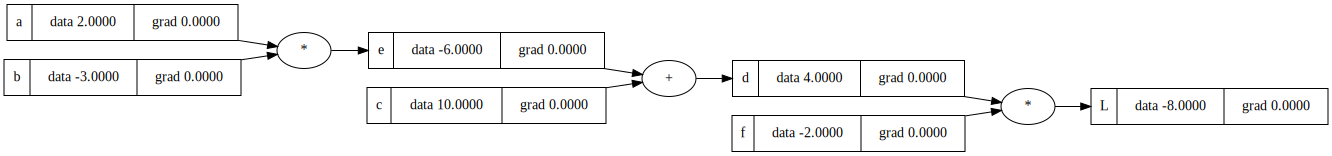

In [79]:
draw_dot(L)

Deriving derivatives:<br>
dd / dc = 1.0
,dd/ de = 1.0<br>
d = c + e<br>
Want:<br>
dL / dc = (dL / dd) * (dd / dc) <br>

Know: <br>
dL / dd <br>
dd / dc

In [80]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0

dL / de = -2.0<br>

I want : <br>
dL/da = (dL / de) * (de/da)<br>

e = a * b <br>
de / da ? b


In [81]:
a.grad = (-2.0*-3.0)
b.grad = -2.0 * 2.0

Inline gradient checking

In [82]:
def lol():
    a = Value(2.0,label = 'a')
    b = Value(-3.0,label = 'b')
    c = Value(10.0,label='c')
    e = a*b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0,label='f')
    L = d*f; L.label='L'
    L1 = L.data
    h = 0.0001

    a = Value(2.0,label = 'a')
    b = Value(-3.0+h,label = 'b')
    c = Value(10.0,label='c')
    e = a*b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0,label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print('derivative = ', (L2-L1)/h)
lol()

derivative =  -4.000000000008441


Preview of a single step of optimization

We nudge L in a positive direction (less negative) 

In [83]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f
print(L.data) 

-7.286496


Squashing function TanH.

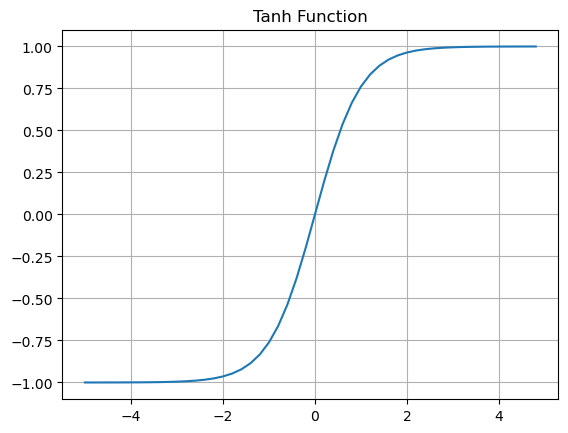

In [84]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));plt.grid();plt.title('Tanh Function');

Back propagating through tiny neural network example

In [85]:
#inputs of nn
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights of nn
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias of nn
b = Value(6.8813735830195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
# we have to implement tanh in Value class
o = n.tanh(); o.label ='o'

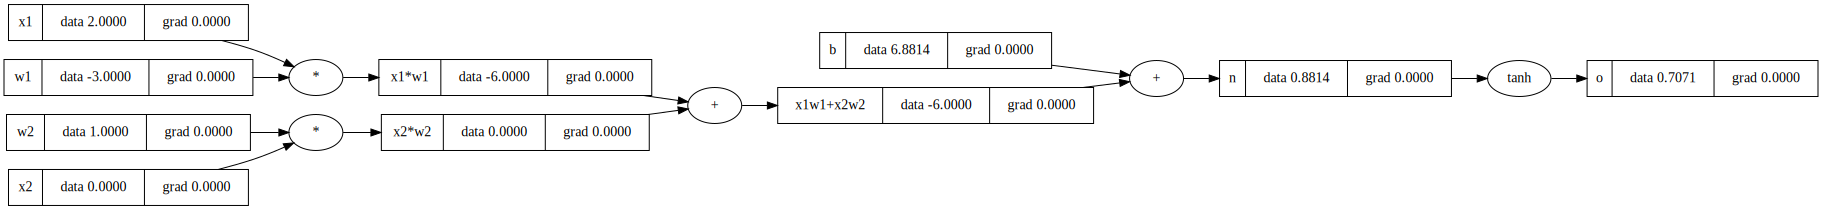

In [86]:
draw_dot(o)

Differentiating on tanh:<br>
differentiate : do/dn = diff(tanh(o)) <br>
diff(tanh(o)) = 1 - tanh(o)\**2
= 1 - o**2

In [87]:
n.grad = 0.5

In [88]:
1-o.data**2

0.5000000028284273

Diff on plus sign just distribute the grad from prev node

In [89]:
x1w1x2w2.grad = b.grad = x1w1.grad = x2w2.grad = 0.5

Diff on multiply sign gives the other term data times the grad of node it's coming from

In [90]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data *x2w2.grad
w2.grad = x2.data *x2w2.grad


Let's implement automatic backward propagation

In [91]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


We want to do back prop without calling backward on each node, so we use topological order algorithm to compute dependencies on the graph and compute all back prop on one step

In [92]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        
        topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373583019543),
 Value(data=0.8813735830195428),
 Value(data=0.7071067791865474)]

In [93]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node.backward()

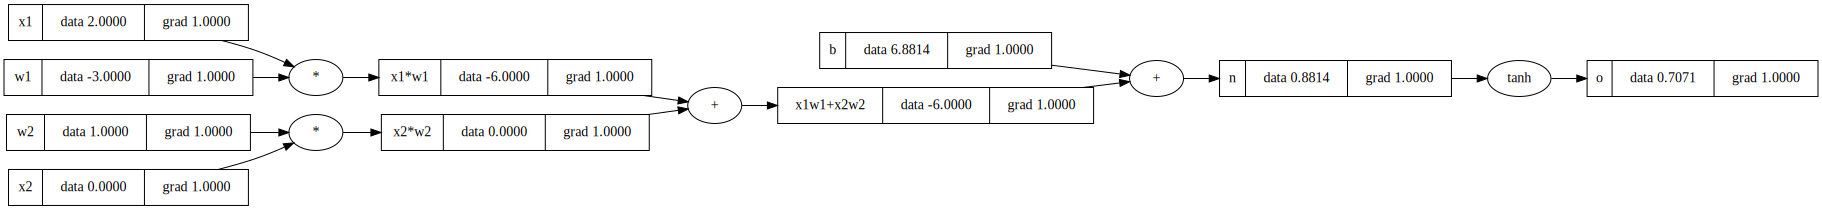

In [94]:
draw_dot(o)

We now add this topological algorithm to Value class as backward function

In [95]:
o.backward()

A bug in the code in the gradient backward functions

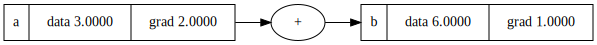

In [96]:
a = Value(3.0,label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

b gradient should be 2.0 because if we differentiate b = a + a should give 1 + 1  = 2.<br> The problem that we don't add the gradient

Another example

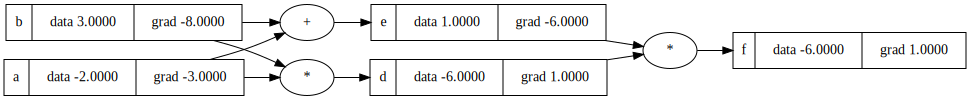

In [97]:
a = Value(-2.0,label = 'a')
b = Value(3.0,label = 'b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d * e ; f.label='f'

f.backward()
draw_dot(f)

We can't do a + 1 , a - 1 , a**2 , a.exp ; assuming 'a' is of class Value so we implemented on the class

now we extract the pieces of tanh 

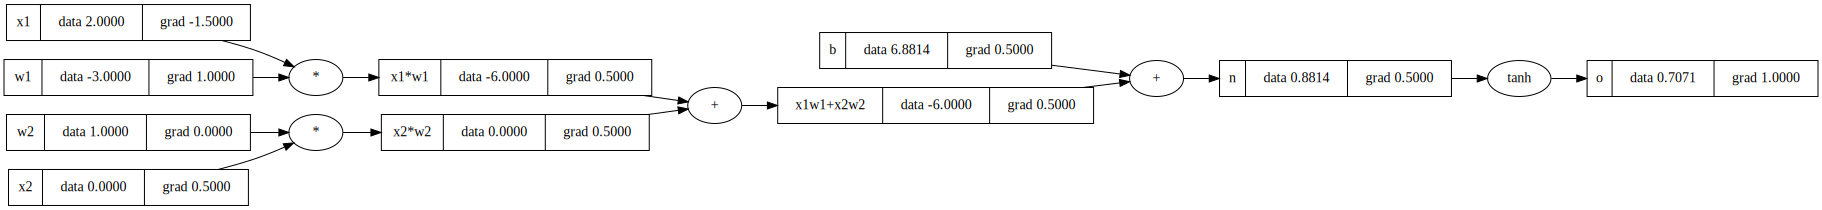

In [98]:
#inputs of nn
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights of nn
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias of nn
b = Value(6.8813735830195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
# we have to implement tanh in Value class
o = n.tanh(); o.label ='o'
o.backward()
draw_dot(o)

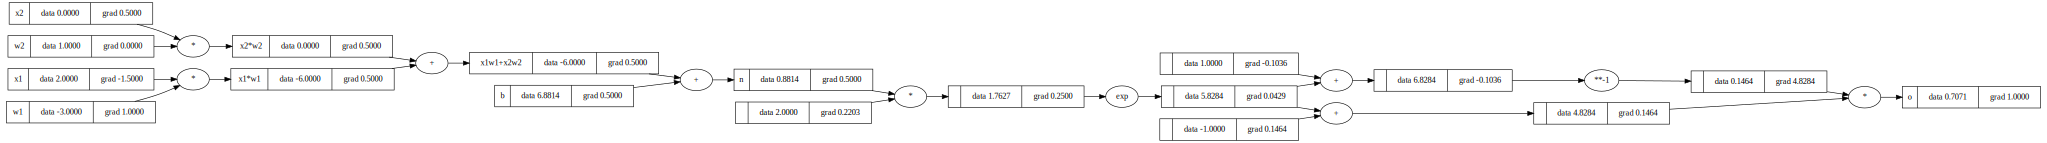

In [99]:
#inputs of nn
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
#weights of nn
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
#bias of nn
b = Value(6.8813735830195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
# we have to implement tanh in Value class
#===============================
e = (2*n).exp()

o = (e-1)/(e+1) ;o.label ='o'

#===============================
o.backward()
draw_dot(o)

We got the same ouputs but with different graph because we divide tanh into small pieces

Creating neural network classes and begins with neuron class

In [100]:
import random
class Neuron:
    
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        act = sum([wi*xi for wi,xi in zip(self.w,x)],self.b)
        out = act.tanh()
        return out
    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0,1.0,-1]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.23403533673593516)

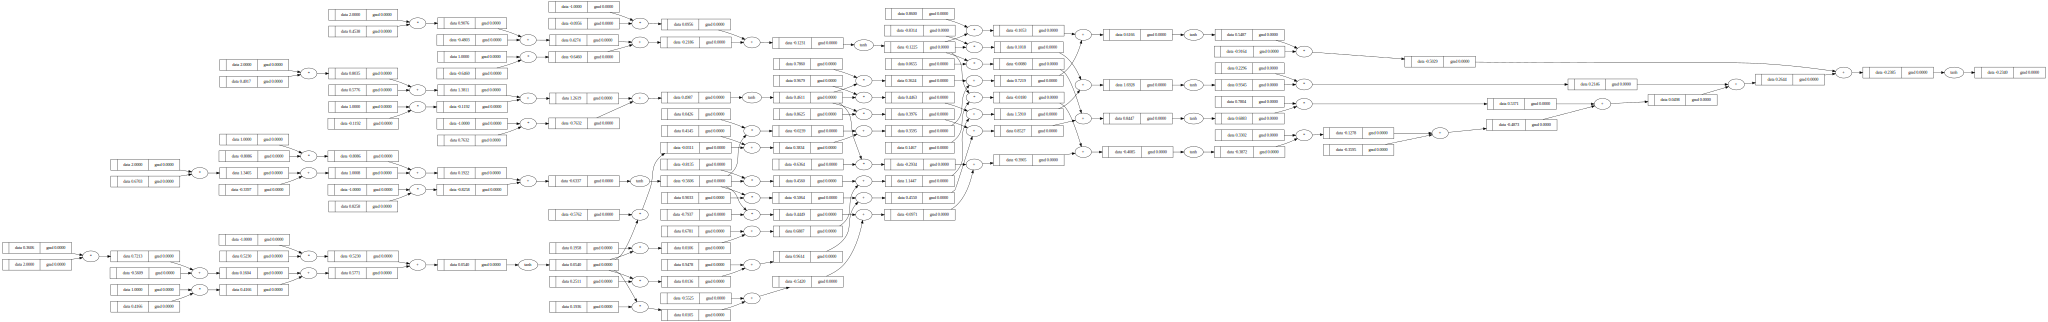

In [101]:
#creating the computational graph of the last nn
draw_dot(n(x))